# Setup

Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gzip
import os
import h5py

Mount data

In [3]:
from google.colab import drive 
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/Group 4/

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1-A7MSZ6V8eP_xZaDJ_j7yN9ddVL8-jgm/Group 4


Load data

In [4]:
root = os.getcwd()
data_path = root + '/eeg_full/'
df = pd.read_csv(data_path+'S1_patient_summary.csv')
hf = h5py.File(data_path+'S1.h5', 'r')
df['Type'] = df['Type'].replace({'c':0, 'a':1})
dat_tensor = np.zeros((len(df), 64, 256))
dat_targets = np.zeros(len(df))
for i in range(len(df)):
    
    pat = df.iloc[i]['Patient']
    tri = '%03d'%df.iloc[i]['Trial']
    
    fname = pat+'.rd.'+tri
    
    dat = np.array(hf.get(fname))
    
    dat_tensor[i] = dat
    dat_targets[i] = df.iloc[i]['Type']

# Transform

- Higuchi fractal dimension: rapidity of signal
- Wavelet decomposition: power in each of five bands per time, symlet mother is usually best in literature
- Normalisation: z-score scaling to handle outliers in signal spikes and set a baseline for each patient trial
- five bands: https://www.nature.com/articles/s41598-017-15966-6#:~:text=Global%20brain%20activity%20is%20conventionally,Hz)%20waves1%2C2.

Frequency-domain data

In [5]:
from numpy.fft import rfft, rfftfreq, irfft

In [6]:
# https://dsp.stackexchange.com/questions/45345/how-to-correctly-compute-the-eeg-frequency-bands-with-python
fs = 256                                # Sampling rate (256 Hz)
data = dat_tensor[0,0]                  # 1 sec of data

# Get real amplitudes of FFT (only in positive frequencies)
fft_vals = np.absolute(rfft(data))
# Get frequencies for amplitudes in Hz
fft_freq = rfftfreq(len(data), 1.0/fs)


Text(0.5, 1.0, 'One electrode, one trial')

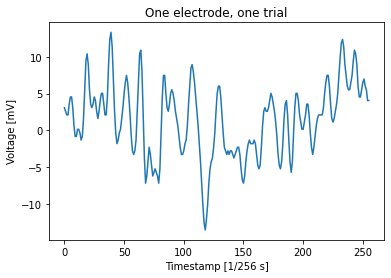

In [8]:
plt.plot(data)
plt.xlabel('Timestamp [1/256 s]')
plt.ylabel('Voltage [mV]')
plt.title('One electrode, one trial')

In [ ]:
fs = 256
data = dat_tensor

fft_vals = np.absolute(rfft(data))
fft_freq = rfftfreq(len(data), 1.0/fs)
eeg_bands = {'Delta': (0, 4),
             'Theta': (4, 8),
             'Alpha': (8, 12),
             'Beta': (12, 30),
             'Gamma': (30, 45)}
eeg_band_fft = dict()
for band in eeg_bands:  
    freq_ix = np.where((fft_freq >= eeg_bands[band][0]) & 
                       (fft_freq <= eeg_bands[band][1]))[0]
    eeg_band_fft[band] = np.mean(fft_vals[freq_ix])

Text(0, 0.5, 'Mean band amplitude')

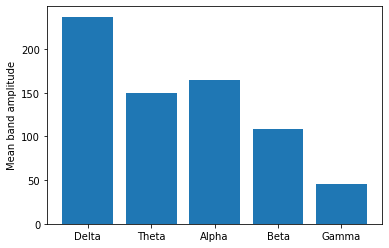

In [ ]:
x = eeg_bands.keys()
y = [eeg_band_fft[band] for band in eeg_bands]
plt.bar(x, y)
plt.ylabel("Mean band amplitude")

In [ ]:
fft_vals.shape

(5477, 64, 129)

Split data

In [ ]:
from sklearn.model_selection import train_test_split
train_tensor, test_tensor, train_target, test_target = train_test_split(
                                            fft_vals, dat_targets, test_size=0.2, random_state=0)

Model

In [ ]:
# For constructing the neural network
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [ ]:
model = keras.models.Sequential()

model.add(layers.Conv2D(23, kernel_size=(5,20), 
                        activation='relu', 
                        input_shape=(64,129,1), 
                        bias_regularizer=regularizers.l1(1e-5),
                        activity_regularizer=regularizers.l1(1e-5),
                        kernel_regularizer=regularizers.l1(1e-5)))
model.add(layers.MaxPooling2D(pool_size=(3,12)))

model.add(layers.Flatten())
model.add(layers.Dense(19, activation='relu',
                       bias_regularizer=regularizers.l1(1e-5),
                       activity_regularizer=regularizers.l1(1e-5),
                       kernel_regularizer=regularizers.l1(1e-5)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=keras.optimizers.SGD(learning_rate=1e-4),
              loss=keras.losses.BinaryCrossentropy(),
              metrics=tf.metrics.BinaryAccuracy())

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 60, 110, 23)       2323      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 9, 23)        0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 4140)              0         
                                                                 
 dense_2 (Dense)             (None, 19)                78679     
                                                                 
 dense_3 (Dense)             (None, 1)                 20        
                                                                 
Total params: 81,022
Trainable params: 81,022
Non-trainable params: 0
__________________________________________________

In [ ]:
history = model.fit(train_tensor, train_target, 
                    epochs = 400,
                    batch_size = 10,
                    validation_split = .2)

Epoch 1/400
351/351 [==============================] - 34s 92ms/step - loss: 1.4829 - binary_accuracy: 0.5848 - val_loss: 0.8018 - val_binary_accuracy: 0.6032
Epoch 2/400
351/351 [==============================] - 34s 96ms/step - loss: 0.7438 - binary_accuracy: 0.6336 - val_loss: 0.7196 - val_binary_accuracy: 0.6055
Epoch 3/400
351/351 [==============================] - 29s 84ms/step - loss: 0.6864 - binary_accuracy: 0.6607 - val_loss: 0.7285 - val_binary_accuracy: 0.5929
Epoch 4/400
351/351 [==============================] - 31s 87ms/step - loss: 0.6611 - binary_accuracy: 0.6701 - val_loss: 0.6689 - val_binary_accuracy: 0.6750
Epoch 5/400
351/351 [==============================] - 29s 84ms/step - loss: 0.6238 - binary_accuracy: 0.6935 - val_loss: 0.6705 - val_binary_accuracy: 0.6739
Epoch 6/400
351/351 [==============================] - 30s 84ms/step - loss: 0.6032 - binary_accuracy: 0.7026 - val_loss: 0.6679 - val_binary_accuracy: 0.7070
Epoch 7/400
351/351 [=========================

In [ ]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')